<a href="https://colab.research.google.com/github/L3borim/Emotional-feedback-and-Perfomance-in-game-Project/blob/main/Project_Graphics_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import glob

# Processamento das capturas e das estatísticas


Duração média para cada round e as emoções possíveis considerando o reconhecimento facial do FER+

In [2]:
ESTIMATED_ROUND_DURATION = 100
EMOCOES_POSSIVEIS = ['anger', 'sadness', 'fear', 'surprise', 'happiness', 'neutral']

Definindo os arquivos de entrada e a lista que armazena todos os rounds

In [3]:
arquivos_emocoes = glob.glob('./detection-results/*.csv')
arquivos_estatisticas = glob.glob('./game-stats/*.csv')

todos_os_rounds = []

## Processamento de cada par de arquivos

In [4]:
for emocoes_path, stats_path in zip(arquivos_emocoes, arquivos_estatisticas):
    emocoes_df = pd.read_csv(emocoes_path)
    emocoes_df['Time'] = emocoes_df['Time'].astype(float)
    estatisticas_df = pd.read_csv(stats_path, delimiter=';')

    for _, round_data in estatisticas_df.iterrows():
        round_num = round_data['Round']
        start_time = (round_num - 1) * ESTIMATED_ROUND_DURATION
        end_time = round_num * ESTIMATED_ROUND_DURATION

        emocoes_round = emocoes_df[(emocoes_df['Time'] >= start_time) & (emocoes_df['Time'] < end_time)]
        emocoes_contagem = emocoes_round['Emotion'].value_counts().to_dict()
        emocoes_contagem.pop('neutral', None)

        round_info = round_data.to_dict()
        round_info.update({em: emocoes_contagem.get(em, 0) for em in EMOCOES_POSSIVEIS})

        if emocoes_contagem:
            round_info['emotion_class'] = max(emocoes_contagem, key=emocoes_contagem.get)
        else:
            round_info['emotion_class'] = 'neutral'

        todos_os_rounds.append(round_info)

## Criação e Configuração do Dataframe
Após o processamento de cada par de arquivos, é criado um dataframe que armazena os resultados de todo esse processamento para posteriormente a análise de dados ser realizada.

In [5]:
analise_df = pd.DataFrame(todos_os_rounds)
analise_df = analise_df.fillna(0)

print(analise_df.head())

Empty DataFrame
Columns: []
Index: []


* Definindo features e alvo

In [ ]:
# Definir features e alvo
X = analise_df[['Kills', 'Deaths', 'Assists', 'Score', 'Round_result'] + EMOCOES_POSSIVEIS]
y = analise_df['emotion_class']

* Dividindo dados de treinamento e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

* Normalizando os dados

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Avaliação dos modelos de classificação

Função auxiliar de demonstraçaõ das métricas de cada modelo de classificação

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, metrics_dict):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    metrics_dict['Model'].append(model_name)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1-Score'].append(f1)

Criação do dicionário de modelos juntamente da realização da avaliação

In [ ]:
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=12),
    "SVM": SVC(kernel='linear', random_state=12),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(random_state=12),
    "Decision Tree": DecisionTreeClassifier(random_state=12)
}

metrics_dict = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    evaluate_model(modelo, X_test, y_test, nome, metrics_dict)

Dataframa das métricas e sua respectica visualização

   Round  Kills  Deaths  Assists  Score        Role  Round_result  anger  \
0      1      0       1        0      0  Controller             1      0   
1      2      1       1        0    150  Controller             1      0   
2      3      0       1        0      0  Controller             0      0   
3      4      0       1        2    195  Controller             0      0   
4      5      1       0        0     75  Controller             0      0   

   sadness  fear  surprise  happiness  neutral emotion_class  
0        0     0         0          0        0       neutral  
1        0     0         0          0        0       neutral  
2        0     0         0         82        0     happiness  
3        0     0         0         49        0     happiness  
4        0     0         0         62        0     happiness  


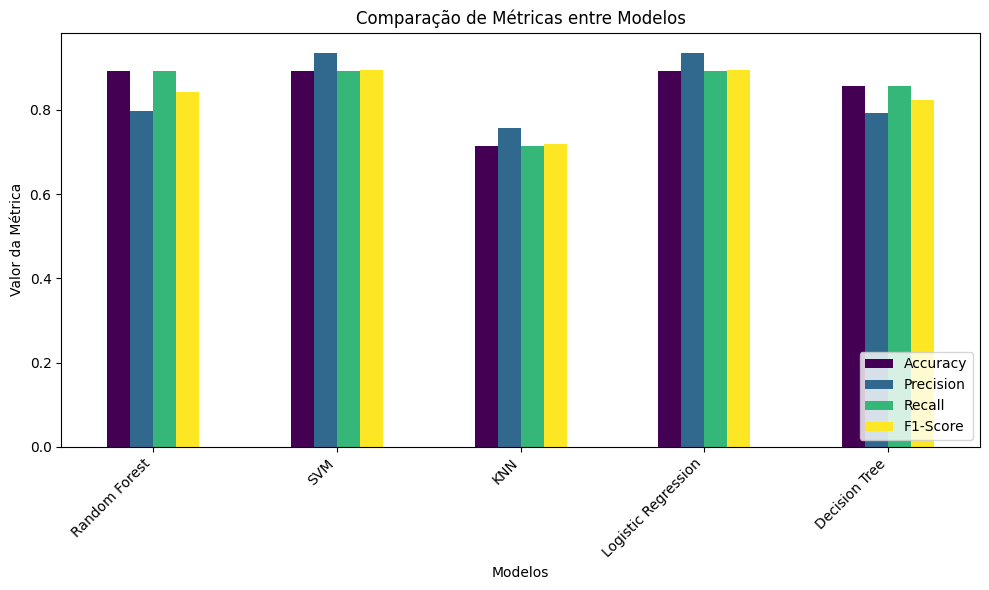

In [ ]:
metrics_df = pd.DataFrame(metrics_dict)

metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparação de Métricas entre Modelos')
plt.ylabel('Valor da Métrica')
plt.xlabel('Modelos')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Operações com o modelo com o melhor desempenho
Selecionando o modelo com a melhor precisão, é possível então realizar as operações de forma identificar o resultado da classificação das emoções de acordo com a performance.

In [ ]:
melhor_modelo_nome = metrics_df['Precision'].idxmax()
melhor_modelo = modelos[melhor_modelo_nome]

###Matriz de Confusão

In [ ]:
y_pred = melhor_modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=melhor_modelo.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_modelo.classes_)

plt.figure(figsize=(8, 6))
cmd.plot(cmap='Blues', ax=plt.gca())
plt.title(f'Matriz de Confusão - {melhor_modelo_nome}')
plt.show()

###Distribuição de Emoções por Resultado da Rodada

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=analise_df, x='Round_result', hue='emotion_class', palette='Set2')
plt.title('Distribuição de Emoções por Resultado da Rodada')
plt.xlabel('Resultado da Rodada')
plt.ylabel('Frequência')
plt.legend(title='Emoções')
plt.show()

###Emoções Dominantes por Rodada

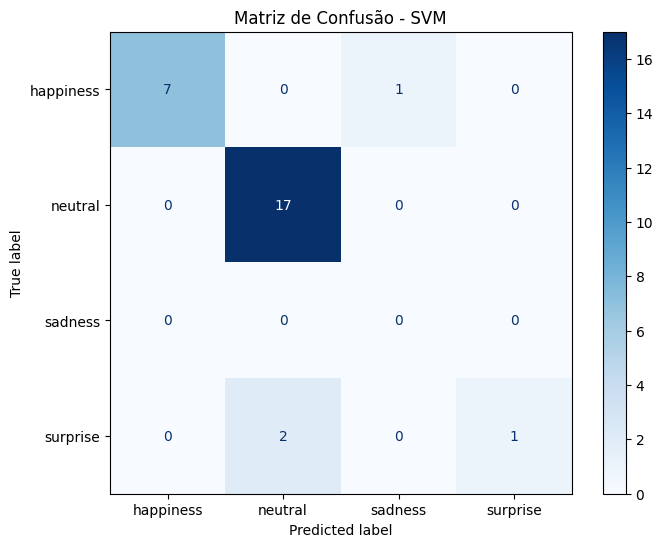

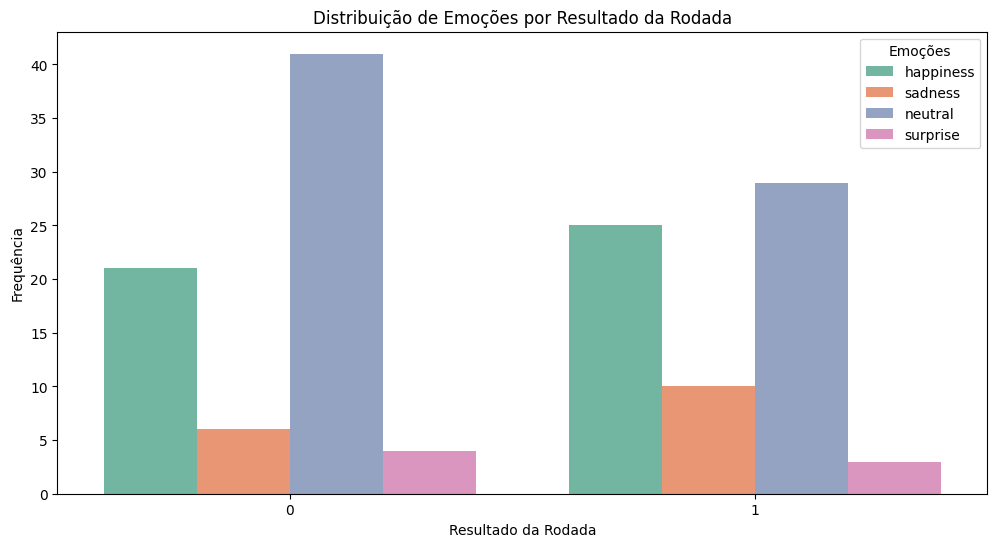

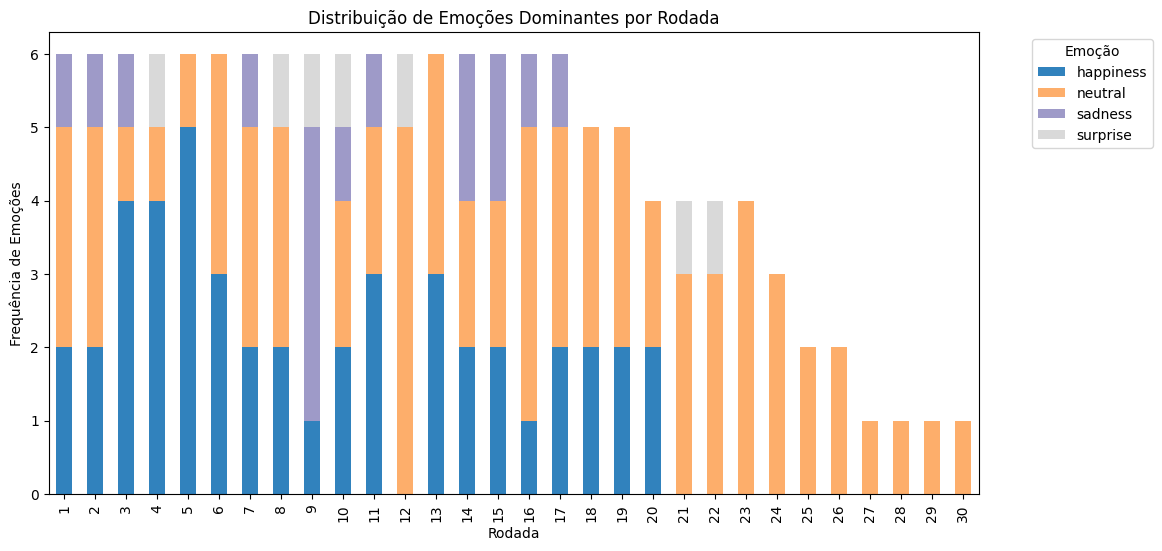

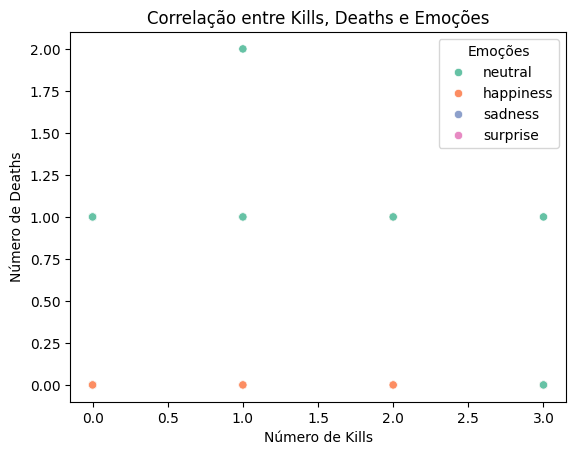

In [ ]:
emotion_distribution = analise_df.groupby('Round')['emotion_class'].value_counts().unstack(fill_value=0)
emotion_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
plt.title('Distribuição de Emoções Dominantes por Rodada')
plt.xlabel('Rodada')
plt.ylabel('Frequência de Emoções')
plt.legend(title='Emoção', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()